# XGBoost

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

## Import datasets

In [107]:
def import_datasets(path: str) -> pd.DataFrame:
    x_train = pd.read_feather(os.path.join(path, 'x_train.feather'))
    y_train = pd.read_csv(os.path.join(path, 'y_train.csv'), index_col=False, header=0)
    y_train = y_train['isFraud']
    x_test = pd.read_feather(os.path.join(path, 'x_test.feather'))
    y_test = pd.read_csv(os.path.join(path, 'y_test.csv'), index_col=False, header=0)
    y_test = y_test['isFraud']

    return x_train, y_train, x_test, y_test

In [108]:
x_train, y_train, x_test, y_test = import_datasets('../data')

In [109]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442903 entries, 0 to 442902
Columns: 228 entries, TransactionAmt to hour_of_day
dtypes: float64(184), int32(30), int64(14)
memory usage: 719.7 MB


In [110]:
def xg_boost_train(x_train: pd.DataFrame, y_train: pd.Series, x_test: pd.DataFrame, y_test: pd.Series):
    clf = xgb.XGBClassifier( 
        learning_rate=0.02, eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4,max_depth=12, 
        n_estimators=2000, subsample=0.8, early_stopping_rounds=100)

    model = clf.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=10)
    
    return model

## Train model

In [111]:
model = xg_boost_train(x_train, y_train, x_test, y_test)

[0]	validation_0-auc:0.79236
[10]	validation_0-auc:0.84545
[20]	validation_0-auc:0.85075
[30]	validation_0-auc:0.85365
[40]	validation_0-auc:0.85860
[50]	validation_0-auc:0.86059
[60]	validation_0-auc:0.86387
[70]	validation_0-auc:0.86583
[80]	validation_0-auc:0.86909
[90]	validation_0-auc:0.87111
[100]	validation_0-auc:0.87590
[110]	validation_0-auc:0.87920
[120]	validation_0-auc:0.88165
[130]	validation_0-auc:0.88308
[140]	validation_0-auc:0.88491
[150]	validation_0-auc:0.88754
[160]	validation_0-auc:0.88927
[170]	validation_0-auc:0.89068
[180]	validation_0-auc:0.89255
[190]	validation_0-auc:0.89483
[200]	validation_0-auc:0.89670
[210]	validation_0-auc:0.89834
[220]	validation_0-auc:0.90054
[230]	validation_0-auc:0.90237
[240]	validation_0-auc:0.90425
[250]	validation_0-auc:0.90617
[260]	validation_0-auc:0.90727
[270]	validation_0-auc:0.90870
[280]	validation_0-auc:0.90996
[290]	validation_0-auc:0.91147
[300]	validation_0-auc:0.91308
[310]	validation_0-auc:0.91409
[320]	validation_0-

## Visualize results using auc metric

In [112]:
def xg_boost_performance(model, x_test: pd.DataFrame, y_test: pd.DataFrame) -> float:
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])

    sns.lineplot(x=fpr, y=tpr)
    plt.show()

    print('Area under roc {}'.format(auc(fpr, tpr)))

    _, ax = plt.subplots(figsize=(10, 12), dpi=80)
    xgb.plot_importance(
        model,
        height=0.75,
        importance_type="gain",
        max_num_features=50,
        show_values=False,
        ax=ax,
    )
    plt.show()

    return auc(fpr, tpr)

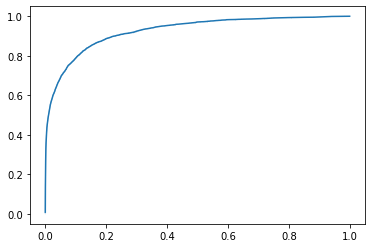

Area under roc 0.9256334068618853


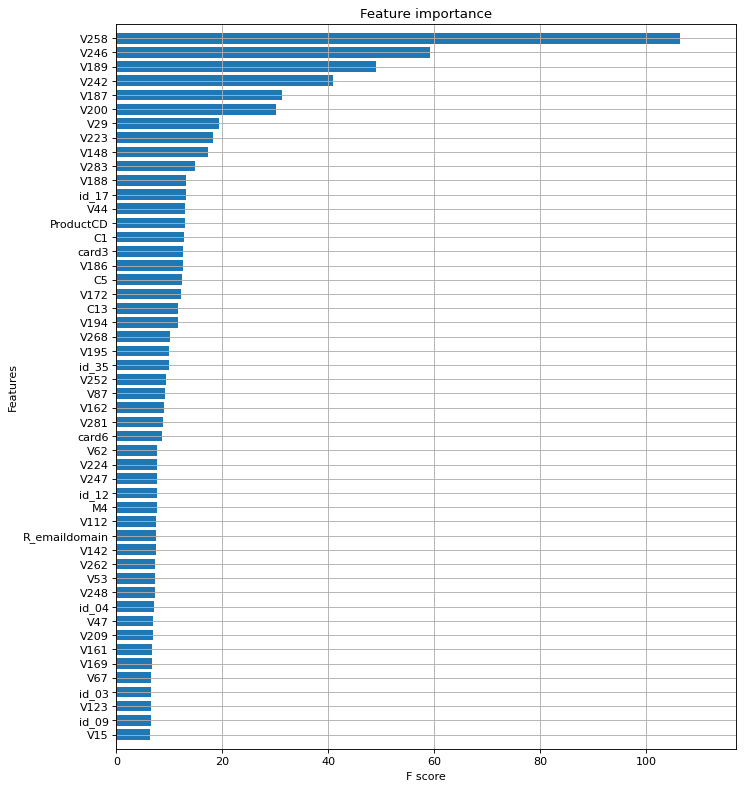

0.9256334068618853

In [113]:
xg_boost_performance(model, x_test, y_test)

## Saving model

In [115]:
model.save_model('../models/xg_boost.json')